In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

## Section 7.1: Estimation {-}

### Section 7.1.1: Unbiasedness and Consistency {-}

In [2]:
# simulation parameters
n = 100 # sample size
mu0 = 0 # mean of Y_i(0)
sd0 = 1 # standard deviation of Y_i(0)
mu1 = 1 # mean of Y_i(1)
sd1 = 1 # standard deviation of Y_i(1)

# generate a sample 
Y0 = stats.norm.rvs(size=n, loc=mu0, scale=sd0)
Y1 = stats.norm.rvs(size=n, loc=mu1, scale=sd1)
tau = Y1 - Y0 # individual treatment effect
# true value of the sample average treatment effect
SATE = tau.mean()
SATE

1.093197115922823

In [3]:
# repeatedly conduct randomized controlled trials
sims = 5000 # repeat 5,000 times, we could do more
diff_means = np.zeros(sims) # container 
sample_vector = np.concatenate((np.ones(int(n/2)), np.zeros(int(n/2))))

for i in range(sims):
    # randomize the treatment by sampling of a vector of 0's and 1's
    treat = np.random.choice(sample_vector, size=n, replace=False)
    # difference-in-means
    diff_means[i] = Y1[treat==1].mean() - Y0[treat==0].mean()

# estimation of error for SATE
est_error = diff_means - SATE

est_error.mean()

0.0006563819230377741

In [4]:
pd.Series(est_error).describe().round(5)

count    5000.00000
mean        0.00066
std         0.14551
min        -0.47547
25%        -0.10010
50%         0.00137
75%         0.10101
max         0.53739
dtype: float64

In [5]:
# PATE simulation
PATE = mu1 - mu0
diff_means = np.zeros(sims)

for i in range(sims):
    # generate a sample for each simulation 
    Y0 = stats.norm.rvs(size=n, loc=mu0, scale=sd0)
    Y1 = stats.norm.rvs(size=n, loc=mu1, scale=sd1)
    treat = np.random.choice(sample_vector, size=n, replace=False)
    diff_means[i] = Y1[treat==1].mean() - Y0[treat==0].mean()

# estimation error for PATE
est_error = diff_means - PATE

# unbiased
est_error.mean()

-0.0030907547870285667

In [6]:
pd.Series(est_error).describe().round(5)

count    5000.00000
mean       -0.00309
std         0.19839
min        -0.65824
25%        -0.14043
50%        -0.00312
75%         0.13004
max         0.71270
dtype: float64

### Section 7.1.2: Standard Error {-}

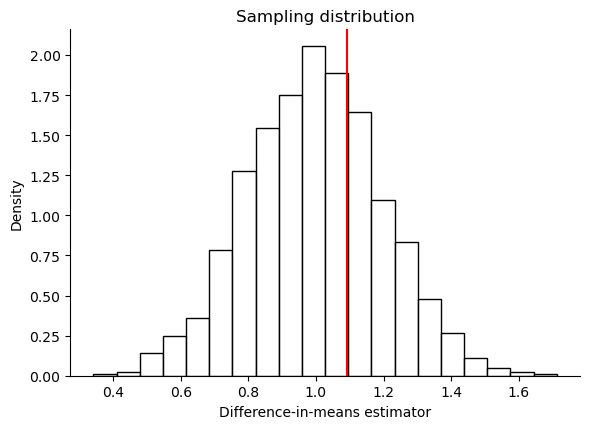

In [7]:
sns.displot(
    diff_means, stat='density', color='white', edgecolor='black',
    height=4, aspect=1.5, bins=20
).set(title='Sampling distribution', xlabel='Difference-in-means estimator')

plt.axvline(SATE, color='red') # true value of SATE

In [8]:
diff_means.std(ddof=1)

0.19838536417616665

In [9]:
np.sqrt(((diff_means - SATE)**2).mean())

0.2204999669265361

In [10]:
# PATE simulation with standard error
sims = 5000
diff_means = np.zeros(sims)
se = np.zeros(sims)

for i in range(sims):
    # generate a sample for each simulation 
    Y0 = stats.norm.rvs(size=n, loc=mu0, scale=sd0)
    Y1 = stats.norm.rvs(size=n, loc=mu1, scale=sd1)
    # randomize treatment by sampling the vector of 0's and 1's created above 
    treat = np.random.choice(sample_vector, size=n, replace=False)
    diff_means[i] = Y1[treat==1].mean() - Y0[treat==0].mean()
    se[i] = (np.sqrt(Y1[treat==1].var(ddof=1) / (n/2) + 
                     Y0[treat==0].var(ddof=1) / (n/2)))
    
diff_means.std(ddof=1)

0.19826469189011459

In [11]:
se.mean()

0.19941849887634452

### Section 7.1.3: Confidence Intervals {-}

In [12]:
n = 1000 # sample size
x_bar = 0.6 # point estimate
s_e = np.sqrt(x_bar * (1-x_bar) / n) # standard error

# 99% confidence intervals; display as a tuple
((x_bar - stats.norm.ppf(0.995) * s_e).round(5), 
 (x_bar + stats.norm.ppf(0.995) * s_e).round(5))

(0.5601, 0.6399)

In [13]:
# 95% confidence intervals
((x_bar - stats.norm.ppf(0.975) * s_e).round(5), 
 (x_bar + stats.norm.ppf(0.975) * s_e).round(5))

(0.56964, 0.63036)

In [14]:
# 90% confidence intervals
((x_bar - stats.norm.ppf(0.95) * s_e).round(5), 
 (x_bar + stats.norm.ppf(0.95) * s_e).round(5))

(0.57452, 0.62548)

In [15]:
# empty container matrices for 2 sets of confidence intervals
ci95 = np.zeros(sims*2).reshape(sims, 2)
ci90 = np.zeros(sims*2).reshape(sims, 2)

# 95 percent confidence intervals
ci95[:,0] = diff_means - stats.norm.ppf(0.975) * se # lower limit
ci95[:,1] = diff_means + stats.norm.ppf(0.975) * se # upper limit

# 90 percent confidence intervals
ci90[:,0] = diff_means - stats.norm.ppf(0.95) * se # lower limit
ci90[:,1] = diff_means + stats.norm.ppf(0.95) * se # upper limit

# coverage rate for 95% confidence interval
((ci95[:,0] <= 1) & (ci95[:,1] >= 1)).mean()

0.9496

In [16]:
# coverage rate for 90% confidence interval
((ci90[:,0] <= 1) & (ci90[:,1] >= 1)).mean()

0.8994

In [17]:
p = 0.6 # true parameter value
n = np.array([50, 100, 1000]) # 3 sample sizes to be examined
alpha = 0.05
sims = 5000 # number of simulations
results = np.zeros(len(n)) # a container for results

for i in range(len(n)):
    ci_results = np.zeros(sims) # a container for whether CI contains truth
    # loop for repeated hypothetical survey sampling
    for j in range(sims):
        data = stats.binom.rvs(n=1, p=p, size=n[i]) # simple random sampling
        x_bar = data.mean() # sample proportion as an estimate
        s_e = np.sqrt(x_bar * (1-x_bar) / n[i]) # standard errors
        ci_lower = x_bar - stats.norm.ppf(1-alpha/2) * s_e
        ci_upper = x_bar + stats.norm.ppf(1-alpha/2) * s_e
        ci_results[j] = (p >= ci_lower) & (p <= ci_upper)
    # proportion of CIs that contain the true value
    results[i] = ci_results.mean()

results

array([0.9466, 0.951 , 0.9466])

### Section 7.1.4: Margin of Error and Sample Size Calculation in Polls {-}

Text(0.32, -250, 'margin of error = 0.05')

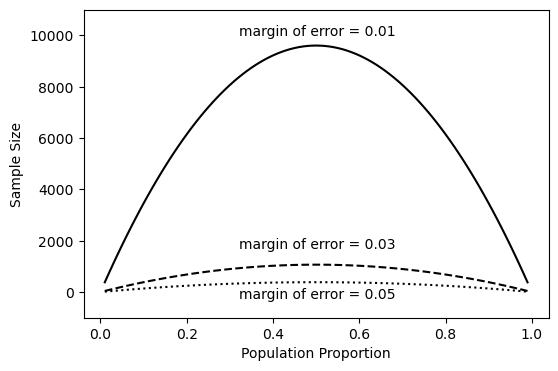

In [18]:
MoE = np.array([0.01, 0.03, 0.05]) # the desired margin of error
p = np.arange(0.01, 1, 0.01)
n = 1.96**2 * p * (1-p) / MoE[0]**2
n2 = 1.96**2 * p * (1-p) / MoE[1]**2
n3 = 1.96**2 * p * (1-p) / MoE[2]**2

fig, ax = plt.subplots(figsize=(6,4))

sns.lineplot(x=p, y=n, ax=ax, color='black').set(
    ylim=(-1000, 11000), xlabel='Population Proportion', ylabel='Sample Size'
)

sns.lineplot(x=p, y=n2, ax=ax, color='black', linestyle='--')

sns.lineplot(x=p, y=n3, ax=ax, color='black', linestyle=':')

# Add text labels
ax.text(0.32, 10000, 'margin of error = 0.01', fontsize=10)
ax.text(0.32, 1700, 'margin of error = 0.03', fontsize=10)
ax.text(0.32, -250, 'margin of error = 0.05', fontsize=10)

In [19]:
# election and polling results, by state
pres08 = pd.read_csv('pres08.csv')
polls08 = pd.read_csv('polls08.csv')

# convert to a date object
polls08['middate'] = pd.to_datetime(polls08['middate'])

# number of days to the election
from datetime import datetime
election_day = datetime.strptime('2008-11-04', '%Y-%m-%d')
polls08['days_to_election'] = (election_day - polls08['middate']).dt.days

# extract unique state names which the loop will iterate through
st_names = polls08['state'].unique()

# create an empty 51 X 3 placeholder Data Frame
poll_pred = pd.DataFrame(np.zeros(51*3).reshape(51, 3), index=st_names)

# loop across the 50 states plus DC
for i in range(len(st_names)):
    # subset the ith state
    state_data = polls08[polls08['state']==st_names[i]]
    # further subset the latest polls within the state
    latest = (state_data['days_to_election']== 
              state_data['days_to_election'].min())
    # compute the mean of the latest polls and store it
    poll_pred.iloc[i, 0] = state_data['Obama'][latest].mean() / 100

# upper and lower confidence limits
n = 1000 # sample size
alpha = 0.05
se = np.sqrt(poll_pred.iloc[:,0] * (1-poll_pred.iloc[:,0]) / n) # standard error
poll_pred.iloc[:,1] = poll_pred.iloc[:,0] - stats.norm.ppf(1-alpha/2) * se
poll_pred.iloc[:,2] = poll_pred.iloc[:,0] + stats.norm.ppf(1-alpha/2) * se

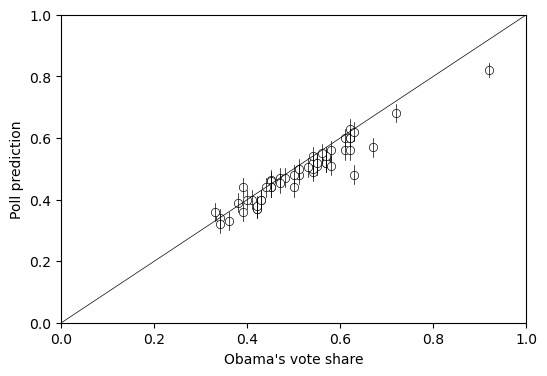

In [20]:
# plot the results
fig, ax = plt.subplots(figsize=(6,4))

sns.scatterplot(
    x = pres08['Obama'] / 100, y = poll_pred.iloc[:,0].reset_index(drop=True), 
    ax=ax, color='white', edgecolor='black'
).set(xlabel="Obama's vote share", ylabel='Poll prediction', 
      xlim=(0, 1), ylim=(0, 1))

ax.axline((0, 0), slope=1, color='black', linewidth=0.5)

# adding 95% confidence intervals for each state 
for i in range(len(st_names)):
    ax.plot(
        [pres08['Obama'][i] / 100] * 2,
        [poll_pred.iloc[i,1], poll_pred.iloc[i,2]], 
        color='black', linewidth=0.5
    )

In [21]:
# proportion of confidence intervals that contain the election day outcome
# reset index: can only compare identically-labeled Series objects
((poll_pred.iloc[:,1].reset_index(drop=True) <= pres08['Obama'] / 100 ) & 
 (poll_pred.iloc[:,2].reset_index(drop=True) >= pres08['Obama'] / 100)).mean()

0.5882352941176471

In [22]:
# bias
bias=(poll_pred.iloc[:,0].reset_index(drop=True) - pres08['Obama']/100).mean()
bias

-0.026797385620915028

In [23]:
# bias corrected estimate
poll_bias = poll_pred.iloc[:,0] - bias

# bias corrected standard error
se_bias = np.sqrt(poll_bias * (1-poll_bias) / n)

# bias corrected confidence intervals
ci_bias_lower = poll_bias - stats.norm.ppf(1-alpha/2) * se_bias
ci_bias_upper = poll_bias + stats.norm.ppf(1-alpha/2) * se_bias

# proportion of bias corrected CIs that contain election day outcome
((ci_bias_lower.reset_index(drop=True) <= pres08['Obama'] / 100) & 
 (ci_bias_upper.reset_index(drop=True) >= pres08['Obama'] / 100)).mean()

0.7647058823529411

### Section 7.1.5: Analysis of Randomized Controlled Trials {-}

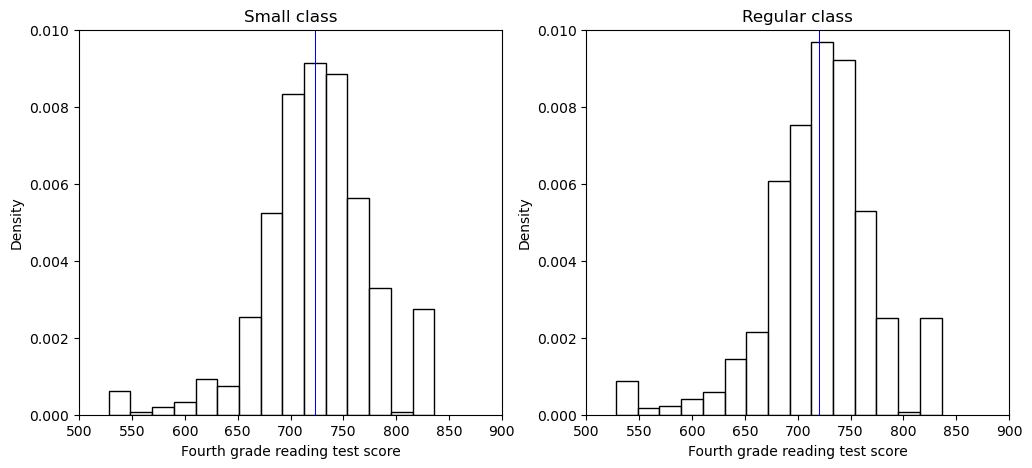

In [24]:
STAR = pd.read_csv('STAR.csv')

fig, axs = plt.subplots(1, 2, figsize=(12,5))

sns.histplot(
    STAR['g4reading'][STAR.classtype==1], stat = 'density', ax=axs[0],
    color='white', edgecolor='black', bins=15
).set(ylim=(0, 0.01), xlim=(500, 900), title='Small class',
      xlabel='Fourth grade reading test score')

axs[0].axvline(STAR['g4reading'][STAR.classtype==1].mean(), 
               color='blue', linewidth=0.75)

sns.histplot(
    STAR['g4reading'][STAR.classtype==2], stat = 'density', ax=axs[1],
    color='white', edgecolor='black', bins=15
).set(ylim=(0, 0.01), xlim=(500, 900), title='Regular class',
      xlabel='Fourth grade reading test score')

axs[1].axvline(STAR['g4reading'][STAR.classtype==2].mean(),
                color='blue', linewidth=0.75)

In [25]:
# estimate and standard error for small class size
n_small = (STAR['classtype']==1 & STAR['g4reading'].notnull()).sum()
est_small = STAR['g4reading'][STAR.classtype==1].mean()
se_small = STAR['g4reading'][STAR.classtype==1].std() / np.sqrt(n_small)
est_small, se_small

(723.3911845730028, 1.9130122952458233)

In [26]:
# estimate and standard error for regular class size
n_regular = ((STAR['classtype']==2) & 
             (STAR['classtype'].notnull()) & 
             (STAR['g4reading'].notnull())).sum()
est_regular = STAR['g4reading'][STAR.classtype==2].mean()
se_regular = STAR['g4reading'][STAR.classtype==2].std() / np.sqrt(n_regular)
est_regular, se_regular

(719.88995215311, 1.8388496908502467)

In [27]:
alpha = 0.05

# 95% confidence intervals for small class size
ci_small = (est_small - stats.norm.ppf(1-alpha/2) * se_small,
            est_small + stats.norm.ppf(1-alpha/2) * se_small)
ci_small

(719.6417493723386, 727.1406197736669)

In [28]:
# 95% confidence intervals for regular class size
ci_regular = (est_regular - stats.norm.ppf(1-alpha/2) * se_regular,
              est_regular + stats.norm.ppf(1-alpha/2) * se_regular)
ci_regular

(716.2858729860609, 723.4940313201591)

In [29]:
# difference in means estimator
ate_est = est_small - est_regular
ate_est

3.5012324198927445

In [30]:
# standard error and 95% confidence interval
ate_se = np.sqrt(se_small**2 + se_regular**2)
ate_se

2.653485298112982

In [31]:
ate_ci = (ate_est - stats.norm.ppf(1-alpha/2) * ate_se,
          ate_est + stats.norm.ppf(1-alpha/2) * ate_se)
ate_ci

(-1.699503197915229, 8.701968037700718)

### Section 7.1.6: Analysis Based on Student’s t-Distribution {-}

In [32]:
# 95% CI for small class 
(est_small - stats.t.ppf(0.975, df=n_small-1) * se_small,
 est_small + stats.t.ppf(0.975, df=n_small-1) * se_small)

(719.635479522832, 727.1468896231735)

In [33]:
# 95% CI based on the central limit theorem
ci_small

(719.6417493723386, 727.1406197736669)

In [34]:
# 95% CI for regular class 
(est_regular - stats.t.ppf(0.975, df=n_regular-1) * se_regular,
 est_regular + stats.t.ppf(0.975, df=n_regular-1) * se_regular)

(716.2806412822123, 723.4992630240077)

In [35]:
# 95% CI based on the central limit theorem
ci_regular

(716.2858729860609, 723.4940313201591)

In [36]:
test_result = stats.ttest_ind(
    STAR['g4reading'][STAR.classtype==1], 
    STAR['g4reading'][STAR.classtype==2],
    # override default equal_var=True; False is Welch t-test 
    equal_var=False, 
    # override default nan_policy='propagate'
    nan_policy='omit')

# we can extract results from the test_result object 
test_result.pvalue

0.18720319784556907

In [37]:
# find the confidence interval 
ci = test_result.confidence_interval(confidence_level=0.95)

# print summary of results
print(
    'Welch Two Sample t-test\n'
    f"t-stat: {test_result.statistic:.4f}\n"
    f"p-value: {test_result.pvalue:.4f}\n"
    f"df: {test_result.df:.1f}\n"
    f"95% confidence interval: ({ci[0]:.4f}, {ci[1]:.4f})"
)

Welch Two Sample t-test
t-stat: 1.3195
p-value: 0.1872
df: 1541.2
95% confidence interval: (-1.7036, 8.7061)


## Section 7.2: Hypothesis Testing {-}

### Section 7.2.1: Tea-Testing Experiment {-}

In [38]:
from math import comb

# truth: enumerate the number of assignment combinations
true = np.array(
    [comb(4,0) * comb(4,4),
     comb(4,1) * comb(4,3),
     comb(4,2) * comb(4,2),
     comb(4,3) * comb(4,1),
     comb(4,4) * comb(4,0)]
)

true

array([ 1, 16, 36, 16,  1])

In [39]:
# compute probability: divide it by the total number of events
true = pd.Series(true / true.sum(), index=[0,2,4,6,8])

true

0    0.014286
2    0.228571
4    0.514286
6    0.228571
8    0.014286
dtype: float64

In [40]:
# simulations
sims=1000
# lady's guess: M stands for 'Milk first', T stands for 'Tea first'
guess=np.array(['M', 'T', 'T', 'M', 'M', 'T', 'T', 'M'])
sample_vector=np.array(['T']*4 + ['M']*4)
correct=pd.Series(np.zeros(sims)) # place holder for number of correct guesses

for i in range(sims):
    # randomize which cups get Milk/Tea first
    cups=np.random.choice(sample_vector, size=len(sample_vector), replace=False)
    correct[i]=(guess==cups).sum() # number of correct guesses

# estimated probability for each number of correct guesses
correct.value_counts(normalize=True).sort_index()

0.0    0.005
2.0    0.209
4.0    0.533
6.0    0.238
8.0    0.015
Name: proportion, dtype: float64

In [41]:
# comparison with analytical answers; the differences are small
correct.value_counts(normalize=True).sort_index() - true

0.0   -0.009286
2.0   -0.019571
4.0    0.018714
6.0    0.009429
8.0    0.000714
dtype: float64

### Section 7.2.2: The General Framework {-}

In [42]:
# all correct
x = pd.DataFrame({'M': [4,0], 'T': [0,4]}, index=['M','T'])
# six correct
y = pd.DataFrame({'M': [3,1], 'T': [1,3]}, index=['M','T'])

x

,M,T
M,4,0
T,0,4


In [43]:
y

,M,T
M,3,1
T,1,3


In [44]:
# one-sided test for 8 correct guesses
fisher_one=stats.fisher_exact(x.values, alternative='greater')

print(
    "Fisher's Exact Test for Count Data: One-Sided\n"
    f"P-value: {fisher_one.pvalue:.5f}"
)

Fisher's Exact Test for Count Data: One-Sided
P-value: 0.01429


In [45]:
# two-sided test for 6 correct guesses 
fisher_two=stats.fisher_exact(y.values)

print(
    "Fisher's Exact Test for Count Data: Two-Sided\n"
    f"P-value: {fisher_two.pvalue:.5f}"
)

Fisher's Exact Test for Count Data: Two-Sided
P-value: 0.48571


### Section 7.2.3: One-Sample Tests {-}

In [46]:
n = 1018
x_bar = 550 / n
se = np.sqrt(0.5 * 0.5 / n) # standard deviation of sampling distribution

# upper red area in the figure
upper = 1 - stats.norm.cdf(x_bar, loc=0.5, scale=se)

# lower red area in the figure; identical to the upper area
lower = stats.norm.cdf(0.5 - (x_bar - 0.5), loc=0.5, scale=se)

# two-sided p-value
upper + lower

0.010168663287718531

In [47]:
2 * upper

0.010168663287718482

In [48]:
# one-sided p-value
upper

0.005084331643859241

In [49]:
z_score = (x_bar - 0.5) / se
z_score

2.5700404773096097

In [50]:
# one-sided p-value
1 - stats.norm.cdf(z_score)

0.005084331643859241

In [51]:
# two-sided p-value
2 * (1 - stats.norm.cdf(z_score))

0.010168663287718482

In [52]:
# 99% confidence interval contains 0.5
(x_bar - stats.norm.ppf(0.995) * se, x_bar + stats.norm.ppf(0.995) * se)

(0.499909283428347, 0.58064081480348)

In [53]:
# 95% confidence interval does not contain 0.5
(x_bar - stats.norm.ppf(0.975) * se, x_bar + stats.norm.ppf(0.975) * se)

(0.5095604956138589, 0.5709896026179682)

In [54]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

# no continuity correction to get the same p-value as above
stat, pval = proportions_ztest(count=550, nobs=n, value=0.5, prop_var=0.5)
ci = proportion_confint(count=550, nobs=n)

print(
    f"One-sample z-test without continuity correction\n"
    f"Alternative hypothesis: true p is not equal to 0.5\n"
    f"Sample proportion: {x_bar:.4f}\n"
    f"Test statistic: {stat:.4f}\n"
    f"P-value: {pval:.4f}\n"
    f"95% confidence interval: ({ci[0]:.4f}, {ci[1]:.4f})"
)

One-sample z-test without continuity correction
Alternative hypothesis: true p is not equal to 0.5
Sample proportion: 0.5403
Test statistic: 2.5700
P-value: 0.0102
95% confidence interval: (0.5097, 0.5709)


The continuity correction factor subtracts 0.5 from the sample proportion before computing the test statistic. The correction factor is not built into the one-sample z-tests available in Python. However, we can build a function to implement the correction using the hypothesis testing logic we have developed.

In [55]:
# Define a function to implement the continuity correction factor
def proportions_ztest_correct(count, nobs, value, conf_level=0.95):
    
    # compute the p-value
    prop = count / nobs
    correction = 0.5 / nobs # Yates' continuity correction
    adjusted_prop = prop - correction
    se_null = np.sqrt(value * (1-value) / nobs) # SE under the null hypothesis
    z_score = np.abs(adjusted_prop-value) / se_null
    # assume a two-tailed test, but we could generalize this
    pval = 2 * (1 - stats.norm.cdf(z_score))

    # compute the confidence interval
    se_sample = np.sqrt(adjusted_prop * (1-adjusted_prop) / nobs)
    alpha = 1-conf_level
    ci_lower = adjusted_prop - stats.norm.ppf(1-alpha/2) * se_sample
    ci_upper = adjusted_prop + stats.norm.ppf(1-alpha/2) * se_sample
    conf_print = int(conf_level * 100)

    print(
        f"One-sample z-test with continuity correction\n"
        f"Alternative hypothesis: true p is not equal to {value}\n"
        f"Sample proportion: {prop:.4f}\n"
        f"Test statistic: {z_score:.4f}\n"
        f"P-value: {pval:.4f}\n"
        f"{conf_print}% confidence interval: ({ci_lower:.4f}, {ci_upper:.4f})"
    )

In [56]:
proportions_ztest_correct(count=550, nobs=n, value=0.5)

One-sample z-test with continuity correction
Alternative hypothesis: true p is not equal to 0.5
Sample proportion: 0.5403
Test statistic: 2.5387
P-value: 0.0111
95% confidence interval: (0.5092, 0.5704)


In [57]:
proportions_ztest_correct(count=550, nobs=n, value=0.5, conf_level=0.99)

One-sample z-test with continuity correction
Alternative hypothesis: true p is not equal to 0.5
Sample proportion: 0.5403
Test statistic: 2.5387
P-value: 0.0111
99% confidence interval: (0.4995, 0.5800)


In [58]:
# two-sided one-sample t-test
star_ttest = stats.ttest_1samp(STAR.g4reading, popmean=710, nan_policy='omit')

ci_lower = star_ttest.confidence_interval()[0]
ci_upper = star_ttest.confidence_interval()[1]

print(
    f"One-sample t-test\n"
    f"Alternative hypothesis: true mean is not equal to 710\n"
    f"Sample mean: {STAR.g4reading.mean():.3f}\n"
    f"t-statistic: {star_ttest.statistic:.3f}\n"
    f"df: {star_ttest.df}\n"
    f"P-value: {star_ttest.pvalue:.5f}\n"
    f"95% confidence interval: ({ci_lower:.3f}, {ci_upper:.3f})"
)

One-sample t-test
Alternative hypothesis: true mean is not equal to 710
Sample mean: 721.248
t-statistic: 10.407
df: 2352
P-value: 0.00000
95% confidence interval: (719.128, 723.367)


### Section 7.2.4: Two-Sample Tests {-}

**In Progress**